In [1]:
import numpy as np
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
columns = ['target','ids','date','flag','user','text']
df = pd.read_csv("./tweet.csv", encoding='ISO-8859-1',names=columns)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.user.value_counts()

user
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
67trinity            1
Sibby                1
mAnyA_15             1
49ersfan111          1
bpbabe               1
Name: count, Length: 659775, dtype: int64

In [8]:
df.date = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S %Y', errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  int64         
 2   date    0 non-null        datetime64[ns]
 3   flag    1600000 non-null  object        
 4   user    1600000 non-null  object        
 5   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 73.2+ MB


## Choix des features

In [8]:
df = df[['target','text']]
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.target.value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [10]:
df.loc[df['target'] == 4, 'target'] = 1
df.target.value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

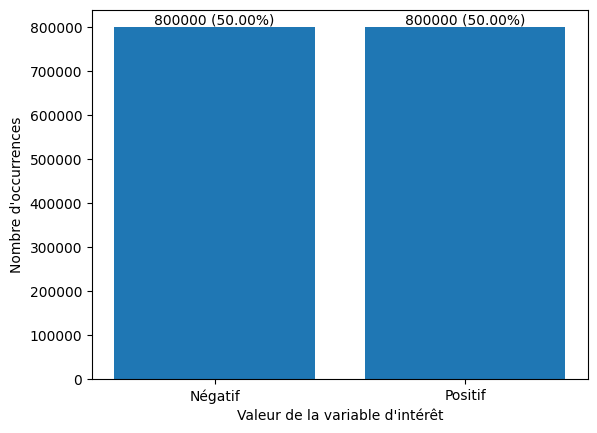

In [11]:
target_counts = df['target'].value_counts()

# Calculer la proportion pour chaque valeur de la variable d'intérêt (target)
target_proportions = df['target'].value_counts(normalize=True)

# Créer un graphique à barres pour visualiser la distribution
plt.bar(target_counts.index, target_counts.values)

# Ajouter les étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(target_counts):
    proportion = target_proportions[i]
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

# Étiqueter l'axe des x et y
plt.xlabel('Valeur de la variable d\'intérêt')
plt.ylabel('Nombre d\'occurrences')

# Ajouter une légende aux barres
plt.xticks(target_counts.index, ['Négatif', 'Positif'])

# Afficher le graphique
plt.show()

In [19]:
# Sélectionner aléatoirement 10 000 tweets positifs
tweets_positifs = df[df['target'] == 1].sample(n=20000, random_state=42)

# Sélectionner aléatoirement 10 000 tweets négatifs
tweets_negatifs = df[df['target'] == 0].sample(n=20000, random_state=42)

# Concaténer les tweets positifs et négatifs sélectionnés
df_select = pd.concat([tweets_positifs, tweets_negatifs])

# Réinitialiser les index
df_select = df_select.reset_index(drop=True)
df_select

,target,ids,date,flag,user,text
0,1,1881179620,NaT,NO_QUERY,tarawade,Is lookin 4ward to a long weekend really dont...
1,1,1970537555,NaT,NO_QUERY,Millie_stillie,#myweakness Is music and i live to meet the p...
2,1,2001154935,NaT,NO_QUERY,zsangel,figured out the Internet on my new iPod
3,1,2053074174,NaT,NO_QUERY,krisignacio,@hillsongunited can't wait to worship with you...
4,1,1793548492,NaT,NO_QUERY,_DrInE_,@sillybeggar Congrats James !! I'm sure the bo...
...,...,...,...,...,...,...
39995,0,2194767980,NaT,NO_QUERY,thej1nx,I have a question to all men out there who are...
39996,0,2192270469,NaT,NO_QUERY,l7babe,@jenndoll it sucks
39997,0,2251986299,NaT,NO_QUERY,ziggysego,My remaining hens were slaughtered my foxes la...
39998,0,2003134338,NaT,NO_QUERY,megntrav,@JohnFinn of course we were at 145am! jordens ...


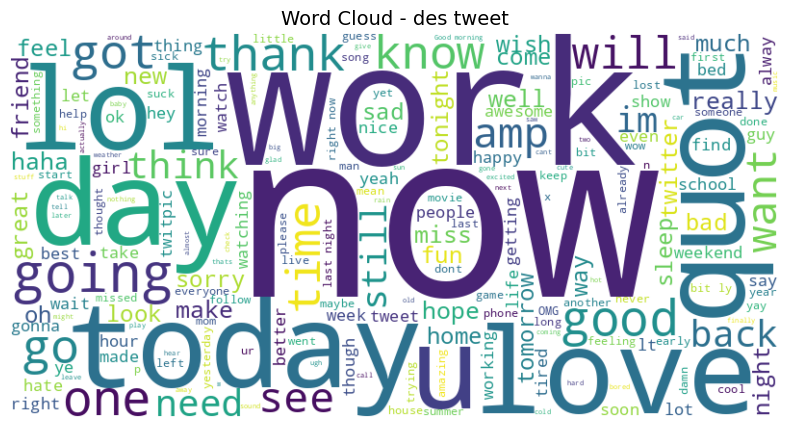

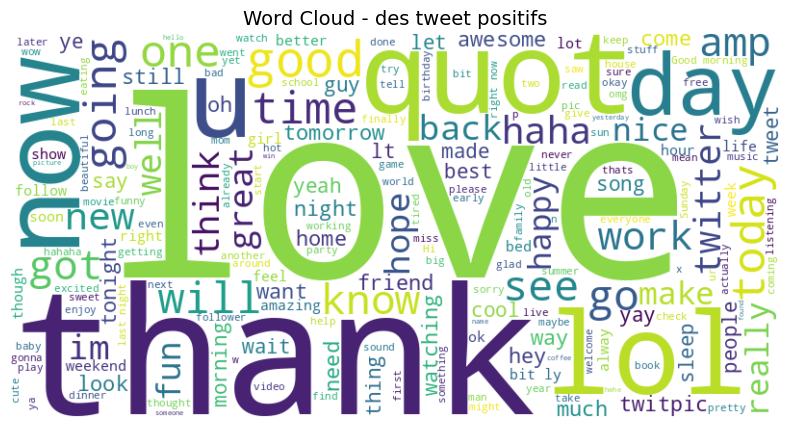

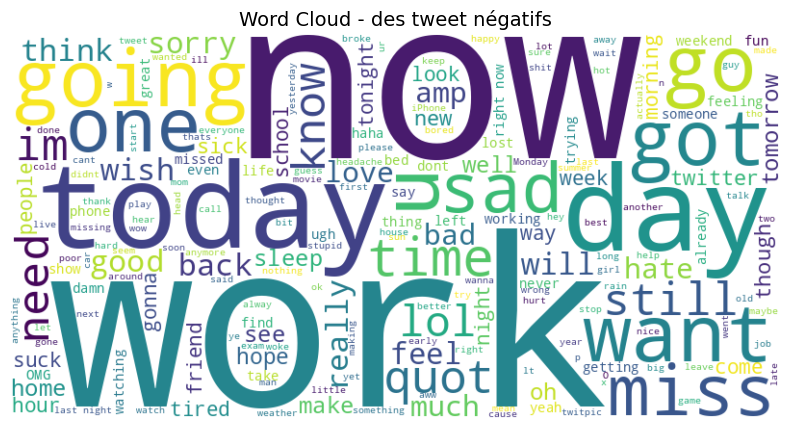

In [20]:
# Fonction pour générer le word cloud
def generer_wordcloud(tweets, titre):
    tout_texte = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

# Générer le word cloud pour chaque type de sentiment
generer_wordcloud(df_select['text'], 'Word Cloud - des tweet')
generer_wordcloud(tweets_positifs['text'], 'Word Cloud - des tweet positifs')
generer_wordcloud(tweets_negatifs['text'], 'Word Cloud - des tweet négatifs')

## Netoyage du text

In [21]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [22]:
nltk.download('wordnet')
# Analyse sémantique, et la génération de synonymes
nltk.download('stopwords')
# Les mots de stopwords sont souvent retirés des textes pour réduire le bruit
nltk.download('punkt')
#  Il divise le texte en phrases et les phrases en mots (ou "tokens")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\radoa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\radoa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\radoa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
# Précompilation des expressions régulières
special_char_pattern = re.compile(r"[^\w\s]")

# Définition des mots vides en dehors de la fonction
stop_words = set(stopwords.words("english"))

def clean_text(text):
    # Suppression des caractères spéciaux et de la ponctuation
    # text = re.sub(r"[^\w\s]", "", text)
    text = special_char_pattern.sub("", text)
    
    # Conversion en minuscules
    text = text.lower()
    
    # Tokenisation du texte
    tokens = word_tokenize(text)
    
    # Suppression des mots vides
    # stop_words = set(stopwords.words("english"))
    # tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in stop_words]
    
    # Joindre les tokens en une seule chaîne
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Appliquer le nettoyage du texte sur la colonne 'texte'
df_select['texte_nettoye'] = df_select['text'].apply(clean_text)

df_select

,target,ids,date,flag,user,text,texte_nettoye
0,1,1881179620,NaT,NO_QUERY,tarawade,Is lookin 4ward to a long weekend really dont...,lookin 4ward long weekend really dont want go ...
1,1,1970537555,NaT,NO_QUERY,Millie_stillie,#myweakness Is music and i live to meet the p...,myweakness music live meet people make
2,1,2001154935,NaT,NO_QUERY,zsangel,figured out the Internet on my new iPod,figured internet new ipod
3,1,2053074174,NaT,NO_QUERY,krisignacio,@hillsongunited can't wait to worship with you...,hillsongunited cant wait worship guys tonight ...
4,1,1793548492,NaT,NO_QUERY,_DrInE_,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar congrats james im sure book going ...
...,...,...,...,...,...,...,...
39995,0,2194767980,NaT,NO_QUERY,thej1nx,I have a question to all men out there who are...,question men married gfare truely loyal respec...
39996,0,2192270469,NaT,NO_QUERY,l7babe,@jenndoll it sucks,jenndoll sucks
39997,0,2251986299,NaT,NO_QUERY,ziggysego,My remaining hens were slaughtered my foxes la...,remaining hens slaughtered foxes last night fr...
39998,0,2003134338,NaT,NO_QUERY,megntrav,@JohnFinn of course we were at 145am! jordens ...,johnfinn course 145am jordens heart got broke ...


## Visualisation en global des mot tirés

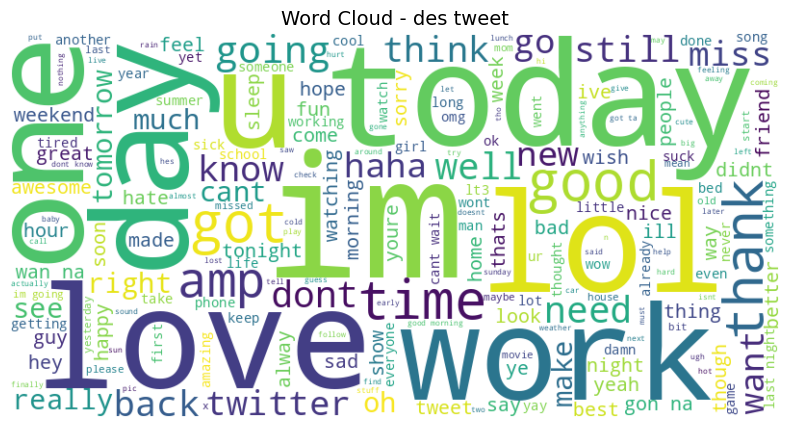

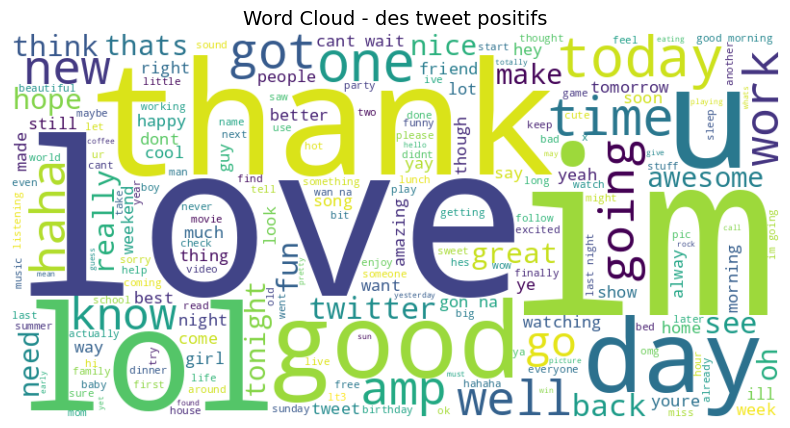

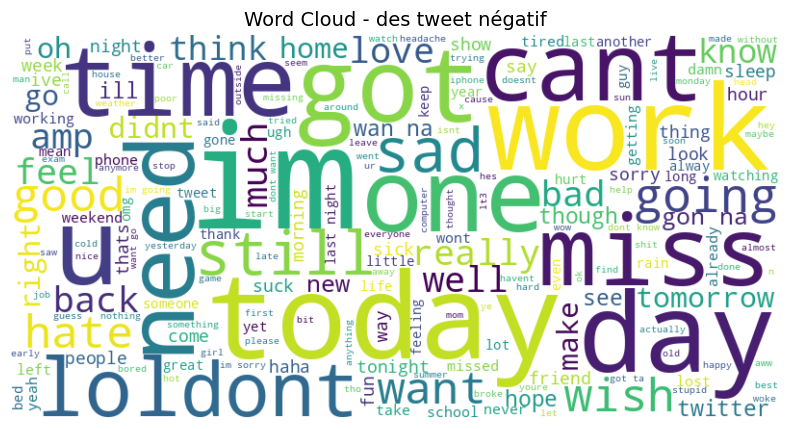

In [24]:
# Générer le word cloud pour chaque type de sentiment
generer_wordcloud(df_select['texte_nettoye'], 'Word Cloud - des tweet')
# Filtrer les tweets positifs
tweets_positifs = df_select[df_select['target'] == 1]['texte_nettoye']
generer_wordcloud(tweets_positifs, 'Word Cloud - des tweet positifs')
# Filtrer les tweets positifs
tweets_negatifs = df_select[df_select['target'] == 0]['texte_nettoye']
generer_wordcloud(tweets_negatifs, 'Word Cloud - des tweet négatif')

## Vectorisation de Texte

In [25]:
# Créer une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'texte_nettoye'
features = vectorizer.fit_transform(df_select['texte_nettoye'])

# Convertir les caractéristiques en une représentation de matrice creuse
# features = features.toarray()

# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", features.shape)

Dimensions de la matrice de caractéristiques : (40000, 55752)


In [26]:
features

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 302701 stored elements and shape (40000, 55752)>

In [27]:
# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(features, df_select['target'], test_size=0.2, stratify=df_select['target'], random_state=42)

## Regression Logistique

In [28]:
# Construire le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédire les probabilités pour les ensembles d'entraînement et de test
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

In [29]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# Calculer les valeurs de la courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

# Calculer l'AUC pour les ensembles d'entraînement et de test
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

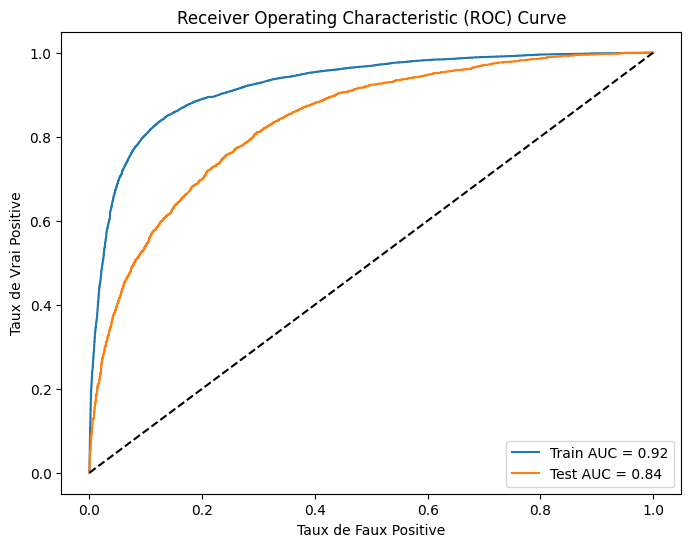

In [30]:
# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC = {:.2f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test AUC = {:.2f}'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de Faux Positive')
plt.ylabel('Taux de Vrai Positive')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [31]:
# Calculer les performances sur les ensembles d'entraînement et de test
train_accuracy = accuracy_score(y_train, model.predict(X_train))
train_precision = precision_score(y_train, model.predict(X_train))
train_recall = recall_score(y_train, model.predict(X_train))
train_f1 = f1_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
test_precision = precision_score(y_test, model.predict(X_test))
test_recall = recall_score(y_test, model.predict(X_test))
test_f1 = f1_score(y_test, model.predict(X_test))

# Créer un tableau des performances
performance_table = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

print(performance_table)

  Performance     Train      Test
0    Accuracy  0.852563  0.754250
1   Precision  0.844257  0.737617
2      Recall  0.864625  0.789250
3    F1 Score  0.854320  0.762560
